# Credit Risk Analysis for Company ABC

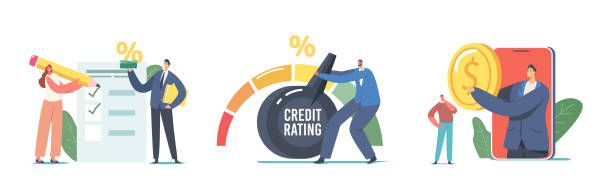

**Credit risk** is associated with the possibility of a client failing to meet contractual obligations, such as mortgages, credit card debts, and other types of loans.

*Minimizing the risk* of default is a major concern for financial institutions. For this reason, ABC Company, which is a credit facility, seeks to rely on machine learning technology to predict which clients are more prone to not honoring their debts.

**Machine Learning** models can help credit facilities such as ABC Company to improve the accuracy of their credit risk analysis by providing a scientific method to identify potential debtors in advance.

In this Notebook, we will build a model to predict the risk of client loan default for ABC Company.
The credit scoring model would predict the customers with good credit class and also determine if and how much credit a customer can be advanced.

In [1]:
!pip install mlxtend #for the sequential feature selector

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install catboost #for the catboost model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.5 MB/s 


# 1. Importing Packages

In this section we import the libraries that will be used throughout data analysis and modelling. 

In [4]:
#Importing libraries
import pandas as pd
import numpy as np
from numpy import argmax
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,cross_validate, GridSearchCV, cross_val_score
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import OneHotEncoder
# Classification report
from sklearn.metrics import classification_report,accuracy_score, f1_score, confusion_matrix, recall_score, precision_score
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs


from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler 
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import pickle
import warnings
warnings.filterwarnings('ignore')

In [5]:
#display all dataframe columns in df.head()
pd.options.display.max_columns = None
#display long string in datafame
#pd.options.display.max_colwidth = 300

In [6]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


# 2.Loading Data
Here we import the data that we'll be using to model and name it as df.

In [7]:
df = pd.read_excel (r'/content/drive/MyDrive/Sendy_credit/Credit Data Analyst - Case Study - Dorcas.xlsx', sheet_name='Credit Data')

# 3.Exploratory Data Analysis
In this section, we perform an in-depth analysis of the variables in the DataFrame.

## 3.1 Data Preview

Let's have a glimpse into the top 5 observations in the dataframe.

In [9]:
# Checking the composition of the top 5 observations in the data.
df.head()

,Name,Credit Class,Gender,Marital Status,Loan_Purpose,Duration,Amount,InstallmentRatePercentage,ResidenceDuration,NumberExistingCredits,NumberPeopleMaintenance,Telephone,ForeignWorker,CheckingAccountStatus_lt_0,CheckingAccountStatus_0_to_200,CheckingAccountStatus_gt_200,CheckingAccountStatus_none,CreditHistory_NoCredit_AllPaid,CreditHistory_ThisBank_AllPaid,CreditHistory_PaidDuly,CreditHistory_Delay,CreditHistory_Critical,SavingsAccountBonds_lt_100,SavingsAccountBonds_100_to_500,SavingsAccountBonds_500_to_1000,SavingsAccountBonds_gt_1000,SavingsAccountBonds_Unknown,EmploymentDuration_lt_1,EmploymentDuration_1_to_4,EmploymentDuration_4_to_7,EmploymentDuration_gt_7,EmploymentDuration_Unemployed,OtherDebtorsGuarantors_None,OtherDebtorsGuarantors_CoApplicant,OtherDebtorsGuarantors_Guarantor,Property_RealEstate,Property_Insurance,Property_CarOther,Property_Unknown,OtherInstallmentPlans_Bank,OtherInstallmentPlans_Stores,OtherInstallmentPlans_None,Housing_Rent,Housing_Own,Housing_ForFree,Job_UnemployedUnskilled,Job_UnskilledResident,Job_SkilledEmployee,Job_Management_SelfEmp_HighlyQualified
0,John,Good,M,Single,Electronics,6.0,1169.0,4.0,4.0,2.0,1.0,N,Y,Y,N,N,N,N,N,N,N,Y,N,N,N,N,Y,N,N,N,Y,N,Y,N,N,Y,N,N,N,N,N,Y,N,Y,N,N,N,Y,N
1,Stella,Bad,F,Married,Electronics,48.0,5951.0,2.0,2.0,1.0,1.0,Y,Y,N,Y,N,N,N,N,Y,N,N,Y,N,N,N,N,N,Y,N,N,N,Y,N,N,Y,N,N,N,N,N,Y,N,Y,N,N,N,Y,N
2,William,Good,M,Single,Vacation,12.0,2096.0,2.0,3.0,1.0,2.0,Y,Y,N,N,N,Y,N,N,N,N,Y,Y,N,N,N,N,N,N,Y,N,N,Y,N,N,Y,N,N,N,N,N,Y,N,Y,N,N,Y,N,N
3,James,Good,M,Single,Furniture,42.0,7882.0,2.0,4.0,1.0,2.0,Y,Y,Y,N,N,N,N,N,Y,N,N,Y,N,N,N,N,N,N,Y,N,N,N,N,Y,N,Y,N,N,N,N,Y,N,N,Y,N,N,Y,N
4,Charles,Bad,M,Single,New Car,24.0,4870.0,3.0,4.0,2.0,2.0,Y,Y,Y,N,N,N,N,N,N,Y,N,Y,N,N,N,N,N,Y,N,N,N,Y,N,N,N,N,N,Y,N,N,Y,N,N,Y,N,N,Y,N


From the above preview of the dataframe, we can see that only 6 features have numerical values, the rest comprise of non-numeric values.

## 3.2 Checking the shape of the dataframe

In [8]:
#Checking the shape of the dataframe
df.shape

(1000, 49)

By checking the shape of the dataframe we can see that the dataset compireses of 49 features and 1000 sample observations. These features are quite alot yet we have not added more features after encoding the categorical variables. To reduce the number of features into a few that are lead to optimal perfomance of each model, we'll use the SequentialFeatureSelector from a library known as mlxtend which works by  iteratively fitting the model to the training dataset, where our dataset starts with one feature, and adds one feature per iteration. For each iteration, k-fold cross-validation is used to compute the performance of the model. Thereafter, we can determine which number of features resulted in the optimal performance for the particular model used as different models may optimize perfomance with different selected features.

We'll then compare the perfomance of each model trained on selected few features and trained on the full features then pick the best one.

## 3.3 Checking for balance in the class labels

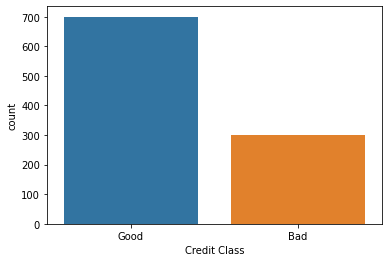

In [12]:
#plotting a bar graph of the count of each class in the target feature
sns.countplot(x = 'Credit Class', data = df)

From the above distribution we can see that there is an imbalance distribution in the two classes of our target feature. The good creditors are more than the bad creditors.


**What is the problem with class imbalance for this analysis?**

Most machine learning algorithms work best when the number of samples in each class are about equal. This is because most algorithms are designed to maximize accuracy and reduce errors.

In our case, given that the data set is imbalanced, our models may give us pretty high accuracies just by predicting the majority class(good debtors), but they may fail to capture the minority class(bad debtors), which is the point of creating our models in the first place.

**How will we deal with the class imbalance problem?**

For this data set we will perfoming resampling which consists of;


* *Random Oversampling* - Randomly duplicate examples in the minority class for the training dataset.
* *Random Undersampling* - Randomly delete examples in the majority class from the training dataset.

We'll achive this using Imblearn's Randomoversampler() and Randomundersampler() for each case respectively.
we'll then train the model on the oversasampled, undersampled and original datasets then choose the best one for our case.

Below is a visualisation of the two techniques for more understanding.

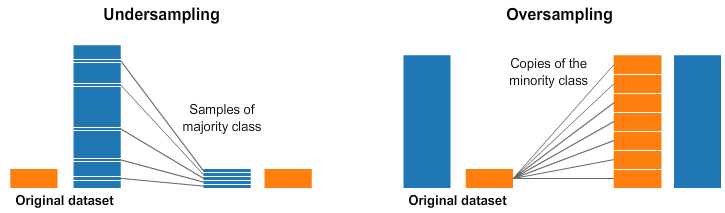

## 3.4 Checking for null values and data types of values within each feature.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 49 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Name                                    1000 non-null   object 
 1   Credit Class                            1000 non-null   object 
 2   Gender                                  1000 non-null   object 
 3   Marital Status                          1000 non-null   object 
 4   Loan_Purpose                            1000 non-null   object 
 5   Duration                                1000 non-null   float64
 6   Amount                                  1000 non-null   float64
 7   InstallmentRatePercentage               1000 non-null   float64
 8   ResidenceDuration                       1000 non-null   float64
 9   NumberExistingCredits                   1000 non-null   float64
 10  NumberPeopleMaintenance                 1000 non-null   float

In [11]:
#this code returns False if there are no null values in the dataframe and True otherwise.
df.isnull().values.any()

False

The data set has 1000 non-null samples or observations and 49 features. Of these features 6 are of numerical data type while the remaining 43 features, are  categorical in nature.
* **Categorical variables** are also known as discrete or qualitative variables. In respect to our data, we can further categorize them into;

 * **Nominal variables** are variables that have two or more categories, but which do not have an intrinsic order.In our case these are all the categorical features except for the target.
 * **Ordinal variables** are variables that have two or more categories just like nominal variables only the categories can also be ordered or ranked. In our case, we have the target in this category.

Before building the model, we will encode these features into numerical values as the models only understand numerical values.


For the Target we will use panda's map function as we want the bad debtors to be labelled as 1 or positive something unachieveable using the popular Labelencoder as it follows alphabetical order when assigning the numerical values. 

For the categorical predictors we will use Sklearn's OneHotencoder.

 
 

## 3.5 Checking the summary statistics of the features in the dataset

### 3.5(a) Summary statistics of the object datatype features.

In [17]:
object_describe = df.describe(include='object')
object_describe.style.background_gradient (cmap='Blues')

,Name,Credit Class,Gender,Marital Status,Loan_Purpose,Telephone,ForeignWorker,CheckingAccountStatus_lt_0,CheckingAccountStatus_0_to_200,CheckingAccountStatus_gt_200,CheckingAccountStatus_none,CreditHistory_NoCredit_AllPaid,CreditHistory_ThisBank_AllPaid,CreditHistory_PaidDuly,CreditHistory_Delay,CreditHistory_Critical,SavingsAccountBonds_lt_100,SavingsAccountBonds_100_to_500,SavingsAccountBonds_500_to_1000,SavingsAccountBonds_gt_1000,SavingsAccountBonds_Unknown,EmploymentDuration_lt_1,EmploymentDuration_1_to_4,EmploymentDuration_4_to_7,EmploymentDuration_gt_7,EmploymentDuration_Unemployed,OtherDebtorsGuarantors_None,OtherDebtorsGuarantors_CoApplicant,OtherDebtorsGuarantors_Guarantor,Property_RealEstate,Property_Insurance,Property_CarOther,Property_Unknown,OtherInstallmentPlans_Bank,OtherInstallmentPlans_Stores,OtherInstallmentPlans_None,Housing_Rent,Housing_Own,Housing_ForFree,Job_UnemployedUnskilled,Job_UnskilledResident,Job_SkilledEmployee,Job_Management_SelfEmp_HighlyQualified
count,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
unique,1000,2,2,3,9,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,John,Good,M,Single,Electronics,Y,Y,N,N,N,N,N,N,Y,N,N,Y,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,Y,N,Y,N,N,N,Y,N
freq,1,700,690,548,307,596,963,726,731,937,606,960,951,530,912,707,603,897,937,952,817,828,661,826,747,938,907,959,948,718,768,668,846,861,953,814,821,713,892,978,800,630,852


We can see that only two features have more than 2 unique features, that is the Marital status and Loan purpose. This is no cause of alarm as the onehotencoder can still handle them effectively. We can also see that the majority of sample observations are from males and also single people. The most common reason also for taking a loan is for Electronics purposes. 
Another important observation is that the observations are from unique clients as indicated by the frequency of each name.

### 3.5(b) Summary statistics of the numerical features

In [13]:
num_describe = df.describe() 
num_describe.style.background_gradient(cmap='Blues')

,Duration,Amount,InstallmentRatePercentage,ResidenceDuration,NumberExistingCredits,NumberPeopleMaintenance
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,4.000000,2.000000


As observed the summary statistics of duration and amount exceed by far those of the other four features, that is, InstallmentRatePercentage,	ResidenceDuration,	NumberExistingCredits and	NumberPeopleMaintenance. This could be attributted to the fact that the values in these last four features, range between 1 and 4.

The values of these features also differ in terms of range, duration and amount have a wider range of values than the other four features. Knowing that not all variables are measured on the same scale for these numerical features, there's need for scaling to allow each feature a fair chance at contributing to modelling. For this we'll use Sklearn's StandardScaler(). 

On the other hand, the maximum value for both duration and amount differ greatly from their respective means. This could be attributed to the presence of outliers in these two features.
In the next step we will be chcking for outliers in the two features and deliberate on how to handle them.

## 3.6 Checking for outliers in both amount and duration features.
We willl plot a box plot for each feature to check for the outliers

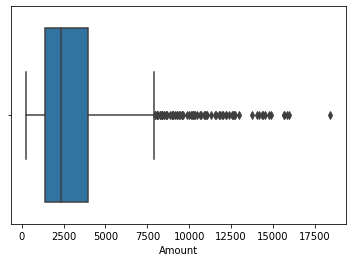

In [43]:
#plotting a box plot using seaborn to check for outliers in the feature, amount.
sns.boxplot(x=df['Amount'])

plt.show()

In [45]:
#a glimpse into the observation with the extreme amount
df[df['Amount']>16000]

,Name,Credit Class,Gender,Marital Status,Loan_Purpose,Duration,Amount,InstallmentRatePercentage,ResidenceDuration,NumberExistingCredits,NumberPeopleMaintenance,Telephone,ForeignWorker,CheckingAccountStatus_lt_0,CheckingAccountStatus_0_to_200,CheckingAccountStatus_gt_200,CheckingAccountStatus_none,CreditHistory_NoCredit_AllPaid,CreditHistory_ThisBank_AllPaid,CreditHistory_PaidDuly,CreditHistory_Delay,CreditHistory_Critical,SavingsAccountBonds_lt_100,SavingsAccountBonds_100_to_500,SavingsAccountBonds_500_to_1000,SavingsAccountBonds_gt_1000,SavingsAccountBonds_Unknown,EmploymentDuration_lt_1,EmploymentDuration_1_to_4,EmploymentDuration_4_to_7,EmploymentDuration_gt_7,EmploymentDuration_Unemployed,OtherDebtorsGuarantors_None,OtherDebtorsGuarantors_CoApplicant,OtherDebtorsGuarantors_Guarantor,Property_RealEstate,Property_Insurance,Property_CarOther,Property_Unknown,OtherInstallmentPlans_Bank,OtherInstallmentPlans_Stores,OtherInstallmentPlans_None,Housing_Rent,Housing_Own,Housing_ForFree,Job_UnemployedUnskilled,Job_UnskilledResident,Job_SkilledEmployee,Job_Management_SelfEmp_HighlyQualified
915,Carolina,Bad,F,Married,Other,48.0,18424.0,1.0,2.0,1.0,1.0,N,N,N,Y,N,N,Y,N,N,N,N,Y,N,N,N,N,N,Y,N,N,N,Y,N,N,N,Y,N,N,Y,N,N,N,Y,N,N,N,N,Y


The box plot confirms our initial guess that there are outliers. The extreme observation is the loan amount of 18424 that had the maximum value in the descriptive statistics. We will however not drop this outlier, neither handle it any way different. The reason for this decision is that maybe this particular client holds a large bank account and hence her applying for such a big amount as compared to the rest.Maybe she had a unique reason hence the loan purpose being classified as other or even worse maybe she is also a fraud. Regardless of the reason, we want to build a model that can handle such extremities well in the event they occur, while minimizing company loss. Afterall that's the sole reason for perfoming this risk anlysis.  

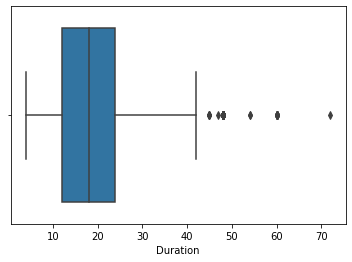

In [30]:
#plotting a box plot using seaborn to check for outliers in the feature, duration.
sns.boxplot(x=df['Duration'])

plt.show()

The boxplot confirms that there are outliers in the feature duration. We will also leave these outliers as just that. Why so? Duration of loan repayment is determined by different factors like client preference and could affect other factors like interest rate. For this reason, disparity in loan duration is bound to always occur and we'd prefer to build a model that can capture this usual occurence and make a prediction that is loss minimising prediction to the company. 

## 3.7 Checking the distribution of some features for the different credit classes
Here we will have more visualizations on the relationship between the credit class and other features


### 3.7a) Amount distribution for each credit class

<Figure size 1440x720 with 0 Axes>

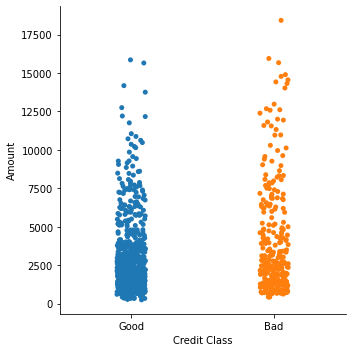

In [16]:
#plotting a catplot on the loan amounts for the different credit classes
plt.figure(figsize=[20,10])
sns.catplot(x ='Credit Class', y= 'Amount', data=df);

From the catplot above we can see that more of the bad creditors tend to go for the higher loans as compared to their counterparts the good creditors

### 3.7b) Loan purpose distribution for each credit class

In [19]:
#creating two dataframes for each credit class, to help us in the next visualization
good = df[df['Credit Class'] == 'Good']
bad = df[df['Credit Class'] == 'Bad']

In [21]:
#plotting the loan purpose distribution for the good creditors
fig1 = px.histogram(good,x='Loan_Purpose',color='Credit Class')
fig1.show()

As observed in the above plot, most of the good creditors tend to go for the loans with the purpose being electronics. Few however take the loans for training, repairs and other purposes. These Electronics could be capital investments that are able to generate income for these clients hence explaining their ability to pay back the loans.

In [22]:
#plotting the loan purpose distribution for the bad creditors
fig1 = px.histogram(bad,x='Loan_Purpose',color='Credit Class')
fig1.show()

As observed in the above plot, most of the bad creditors tend to take loans for the purpose of purchasing new cars. These cars could be a liability to them and not an asset and hence them defaulting on their loan repayments.

### 3.7c) Marital status distribution for each credit class

In [24]:
#plotting the Marital status distribution for the good creditors
fig1 = px.histogram(good,x='Marital Status',color='Credit Class')
fig1.show()

From the plot above we can see that majority of the good creditors are single. Could it be that these single people are more likely to risk in making financial investments hence them taking more loans unlike their married counterparts who are more likely burdened with responsibilities and are less likely to make investments? How about the Divorcees? Are they taking each day at a time with less likelihood of taking risks with investments? 

let's take a further look on the marital status distribution of the bad creditors.

In [25]:
#plotting the Marital status distribution for the bad creditors
fig1 = px.histogram(bad,x='Marital Status',color='Credit Class')
fig1.show()

Well both credit classes have an almost similar distribution in relation to the marital status. We can really 'judge' either side, we will leave that to the model!

### 3.7d) Gender distribution for each credit class

In [26]:
#plotting the Gender distribution for the good creditors
fig1 = px.histogram(good,x='Gender',color='Credit Class')
fig1.show()

From the above plot we can see that there are more males than females who are good creditors. The reason could be that males are smarter investors than women or that few females than males comprise the sample observations in this dataset.

Let's take a look on the gender distribution for the bad creditors.

In [27]:
#plotting the Gender distribution for the bad creditors
fig1 = px.histogram(bad,x='Gender',color='Credit Class')
fig1.show()

In [28]:
#checking for the count of the two genders in the main dataset
df['Gender'].value_counts()

M    690
F    310
Name: Gender, dtype: int64

From this plot we can see that the count of males exceeds the one for females among bad creditors and can most likely be explained by the fact that there are more male than female sample observations.

We've come to the end of our exploratory data analysis and I must say we've had some fun and quite the insights drawn.

**Key takeaways from the EDA to be handled in the Feature Engineering and modelling stages;**

 * The data set comprises of both numerical and non-numerical data types
 * Some of the numerical features have a wider range of values than others
 * The dataset is imbalanced with regards to the target classes.

# 4.Feature Engineering
At this stage we will be perfoming some transformations on the features in the dataset in preparation for modelling.

## 4.1 Creating a list of all categorical features to be used as predictors
Her we create a list of all the categorical features we will be working with as predictors in the model. 
We will also drop the name feature as they are all unique for each observation and so it's not useful to retain it.
The credit class feature will also not be included in this list of predictors as it is the target, we are aiming at predicting.


In [8]:
#creating the list as nominals
notinclude=['Name', 'Credit Class']
nominals=[]
for i in df.columns:
  if df[i].dtype=='object' and i not in notinclude:
    nominals.append(i)


## 4.2 Encoding the categorical predictor features
As observed earlier in the exploratory data analysis most of these predictor features have non-numeric values which will need to be transformed to numeric for the model to handle them. 

For that we will be using Sklearn's OneHotEncoder a technique which is used to convert or transform a categorical feature having string labels into K numerical features in such a manner that the value of one out of K (one-of-K) features is 1 and the value of rest (K-1) features is 0. Also to avoid having two or more dummy variables having a perfect correlation we wil drop first for each feature encoding so that we can have k-1 variables instead of k variables.

In [9]:
#creating a copy of the main dataframe that we will use onehotencoder on
df_ohe = df.copy()      

In [10]:
#dropping the target(credit class) and name feature as we won't be onehotencoding them
df_ohe = df_ohe.drop(['Name','Credit Class'], axis=1)

In [11]:
#instantiating one hot encoder
ohe = OneHotEncoder(drop='first')

In [12]:
#One-hot-encode the nominal columns.
array_hot_encoded = ohe.fit_transform(df_ohe[nominals]).toarray()

In [13]:
#extracting the featurelabels after encoding . To be used in building the final dataframe
feature_labels = ohe.get_feature_names()

In [14]:
feature_labels = np.array(feature_labels).ravel() #using ravel to get a flattened 1D array of the feature labels

In [15]:
#Converting the encoded data into a dataframe
data_hot_encoded = pd.DataFrame(array_hot_encoded,columns=feature_labels, index=df_ohe.index)

In [16]:
#Extract only the columns that didnt need to be encoded to later join with the encoded data
data_other_cols = df_ohe.drop(columns=nominals)


In [17]:
#a glimpse of our encoded data
data_hot_encoded.head()

,x0_M,x1_Married,x1_Single,x2_Electronics,x2_Furniture,x2_New Car,x2_Other,x2_Repairs,x2_Training,x2_Used Car,x2_Vacation,x3_Y,x4_Y,x5_Y,x6_Y,x7_Y,x8_Y,x9_Y,x10_Y,x11_Y,x12_Y,x13_Y,x14_Y,x15_Y,x16_Y,x17_Y,x18_Y,x19_Y,x20_Y,x21_Y,x22_Y,x23_Y,x24_Y,x25_Y,x26_Y,x27_Y,x28_Y,x29_Y,x30_Y,x31_Y,x32_Y,x33_Y,x34_Y,x35_Y,x36_Y,x37_Y,x38_Y,x39_Y,x40_Y
0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [18]:
#a glimpse of the columns that did not need to be encoded
data_other_cols.head()

,Duration,Amount,InstallmentRatePercentage,ResidenceDuration,NumberExistingCredits,NumberPeopleMaintenance
0,6.0,1169.0,4.0,4.0,2.0,1.0
1,48.0,5951.0,2.0,2.0,1.0,1.0
2,12.0,2096.0,2.0,3.0,1.0,2.0
3,42.0,7882.0,2.0,4.0,1.0,2.0
4,24.0,4870.0,3.0,4.0,2.0,2.0


In [19]:
#Concatenate the two dataframes  
data_out = pd.concat([data_other_cols,data_hot_encoded], axis=1)

In [20]:
#a glimpse of the final dataframe of all the predictor variables
data_out.head()

,Duration,Amount,InstallmentRatePercentage,ResidenceDuration,NumberExistingCredits,NumberPeopleMaintenance,x0_M,x1_Married,x1_Single,x2_Electronics,x2_Furniture,x2_New Car,x2_Other,x2_Repairs,x2_Training,x2_Used Car,x2_Vacation,x3_Y,x4_Y,x5_Y,x6_Y,x7_Y,x8_Y,x9_Y,x10_Y,x11_Y,x12_Y,x13_Y,x14_Y,x15_Y,x16_Y,x17_Y,x18_Y,x19_Y,x20_Y,x21_Y,x22_Y,x23_Y,x24_Y,x25_Y,x26_Y,x27_Y,x28_Y,x29_Y,x30_Y,x31_Y,x32_Y,x33_Y,x34_Y,x35_Y,x36_Y,x37_Y,x38_Y,x39_Y,x40_Y
0,6.0,1169.0,4.0,4.0,2.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,48.0,5951.0,2.0,2.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,12.0,2096.0,2.0,3.0,1.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,42.0,7882.0,2.0,4.0,1.0,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,24.0,4870.0,3.0,4.0,2.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [21]:
#let's see the data types in our final dataframe
data_out.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 55 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Duration                   1000 non-null   float64
 1   Amount                     1000 non-null   float64
 2   InstallmentRatePercentage  1000 non-null   float64
 3   ResidenceDuration          1000 non-null   float64
 4   NumberExistingCredits      1000 non-null   float64
 5   NumberPeopleMaintenance    1000 non-null   float64
 6   x0_M                       1000 non-null   float64
 7   x1_Married                 1000 non-null   float64
 8   x1_Single                  1000 non-null   float64
 9   x2_Electronics             1000 non-null   float64
 10  x2_Furniture               1000 non-null   float64
 11  x2_New Car                 1000 non-null   float64
 12  x2_Other                   1000 non-null   float64
 13  x2_Repairs                 1000 non-null   float6

Now we can see that the data type of all these features is the same and numerical. This can now be used for modelling. The increament in number of features is because of the features generated during encoding.

Now encoding the target feature as well. 

For this one we will map the values such that the bad creditors are assigned 1, that is 'positive' and the good creditors are assigned 0, that is 'negative'.

In [22]:
#encoding the target feature
y = df['Credit Class'].map(lambda x: 1 if x=='Bad' else 0)

In [23]:
#getting the target names
target_names = df['Credit Class'].unique()

In [24]:
print(target_names)

['Good' 'Bad']


Onto the next step, building models, as our data is now ready for modelling!

# 5.Modelling

At this level I will start evaluating the models. I will be considering Precision, Recall and F1 Score as evaluation metrics, for the following reasons:

Precision will give us the proportion of positive identifications that were indeed correct. It can be defined as:
 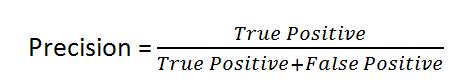
    

Recall will determine the proportion of real positives that were correctly identified, and it can be defined as:
 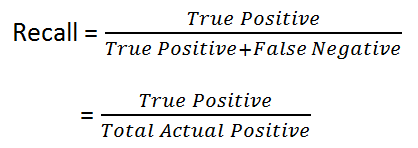

On the other hand, F1 Score is a metric that is useful when we need to seek a balance between precision and recall. The formula is defined as:
 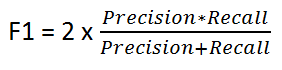

Since our objective is to minimize company loss, predicting the risk of client default, a good recall rate is desirable because we want to identify the maximum amount of clients that are indeed prone to stop paying their debts, thus, we are pursuing a small number of False Negatives.

Additionally, we also seek to minimize the number of False Positives because we don't want clients to be mistakenly identified as defaulters. Therefore, a good precision rate is also desirable.


I chose XGBClassifier as my base model. I fit it in three different datasets, with the main difference between the data sets being the manner in which I resampled the samples with an aim to tackle the imbalance in the target classes distribution.

In [25]:
#splitting the data set into 80% train and 20% test, setting the random state so i get the same data set with each split
X_train, X_test, y_train, y_test = train_test_split(data_out, y, test_size=0.2, random_state=42)

In [26]:
#scaling the predictor variables as they are all measured on different scales. 
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

In [27]:
#instantiating the XGBClassifier model
xgb = XGBClassifier()

In [28]:
#fitting the model on the train data
xgb.fit(X_train, y_train)

XGBClassifier()

In [29]:
# prediction
X_test = scaler.transform(X_test)
y_pred_xgb = xgb.predict(X_test)

In [30]:
#assigning the classification report
clf = classification_report(y_test, y_pred_xgb,target_names=target_names)

In [31]:
print(clf)

              precision    recall  f1-score   support

        Good       0.81      0.91      0.85       141
         Bad       0.68      0.47      0.56        59

    accuracy                           0.78       200
   macro avg       0.74      0.69      0.71       200
weighted avg       0.77      0.78      0.77       200



In [32]:
#asssigning the metrics
f1 = f1_score(y_test, y_pred_xgb)
precision = precision_score(y_test, y_pred_xgb)
recall = recall_score(y_test, y_pred_xgb)
accuracy = accuracy_score(y_test, y_pred_xgb)

In [33]:
#now spliting the data again for modelling with a balanced distribution for the target classes
X_trainb, X_testb, y_trainb, y_testb = train_test_split(data_out, y, shuffle=True, stratify=y, random_state=42) #stratification based on 
#target labels due to the imblance, 
#to ensure that relative class frequencies is approximately preserved in each split

In [34]:
# standardize numerical variables
scaler = StandardScaler().fit(X_trainb)
X_trainb = scaler.transform(X_trainb)

# resample by undersampling
run = RandomUnderSampler()
X_train_run, y_train_run = run.fit_resample(X_trainb, y_trainb)

In [35]:
# final XGBoost model
xgb = XGBClassifier() 
xgb.fit(X_train_run, y_train_run)

XGBClassifier()

In [36]:
# prediction
X_test_run = scaler.transform(X_testb)
y_pred_run = xgb.predict(X_test_run)

In [37]:
# classification report
clf_run = classification_report(y_testb, y_pred_run,target_names=target_names)


In [38]:
print(clf_run)

              precision    recall  f1-score   support

        Good       0.87      0.67      0.76       175
         Bad       0.50      0.76      0.60        75

    accuracy                           0.70       250
   macro avg       0.68      0.72      0.68       250
weighted avg       0.76      0.70      0.71       250



In [39]:
#assigning the metrics
f1 = f1_score(y_testb, y_pred_run)
precision = precision_score(y_testb, y_pred_run)
recall = recall_score(y_testb, y_pred_run)
accuracy = accuracy_score(y_testb, y_pred_run)

In [40]:
#resample by oversampling
rov = RandomOverSampler()
X_train_rov, y_train_rov = run.fit_resample(X_trainb, y_trainb)

In [41]:
#instantiating the XGBClassifier model
xgb = XGBClassifier() 
xgb.fit(X_train_rov, y_train_rov)

XGBClassifier()

In [42]:
#getting predictions
y_pred_rov = xgb.predict(X_test_run)

In [43]:
#assigning metrics
f1 = f1_score(y_testb, y_pred_rov)
precision = precision_score(y_testb, y_pred_rov)
recall = recall_score(y_testb, y_pred_rov)
accuracy = accuracy_score(y_testb, y_pred_rov)

In [45]:
print('No resampling')
print(classification_report(y_test, y_pred_xgb,target_names=target_names))
print()
print('Under sampling')
print(classification_report(y_testb, y_pred_run,target_names=target_names))
print()
print('Over sampling')
print(classification_report(y_testb, y_pred_rov,target_names=target_names))

No resampling
              precision    recall  f1-score   support

        Good       0.81      0.91      0.85       141
         Bad       0.68      0.47      0.56        59

    accuracy                           0.78       200
   macro avg       0.74      0.69      0.71       200
weighted avg       0.77      0.78      0.77       200


Under sampling
              precision    recall  f1-score   support

        Good       0.87      0.67      0.76       175
         Bad       0.50      0.76      0.60        75

    accuracy                           0.70       250
   macro avg       0.68      0.72      0.68       250
weighted avg       0.76      0.70      0.71       250


Over sampling
              precision    recall  f1-score   support

        Good       0.83      0.67      0.74       175
         Bad       0.47      0.68      0.56        75

    accuracy                           0.68       250
   macro avg       0.65      0.68      0.65       250
weighted avg       0.72      

As observed in the three Classification reports, the model perfomed best without any resampling. This coclusion is based on the weighted average scores for both the recall and F1 score. It is for this reason that I will fit and test different models based on the imbalanced data set.

## 5.1 Building and comparing perfomance of more base models on the full dataset

In [58]:
#assigning the names of the models as names and the models as classifiers to beused in making the dataframe on the perfomances
names = ['Linear SVM', 'RBF SVM','XGBClassifier', 'CatBoostClassifier','LogisticRegression','LGBMClassifier']
classifiers = [SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),XGBClassifier(), CatBoostClassifier(),LogisticRegression(),  LGBMClassifier()]

In [59]:
#creating a dataframe on all the models perfomances 
results = []

models = {}


for name, clf in zip(names, classifiers):
    print ('Fitting {:s} model...'.format(name))
    run_time = %timeit -q -o clf.fit(X_train, y_train)

    print ('... predicting')
    y_pred = clf.predict(X_test)

    print ('... scoring')
    accuracy  = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall    = metrics.recall_score(y_test, y_pred)
    f1        = metrics.f1_score(y_test, y_pred)
    

    # Save the results to dictionaries
    models[name] = clf
    results.append([name, accuracy, precision, recall, f1, run_time.best])


results = pd.DataFrame(results, columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1', 'Train Time'])
results.set_index('Classifier', inplace= True)

print ('... All done!')

Streaming output truncated to the last 5000 lines.
13:	learn: 0.6482539	total: 29.1ms	remaining: 2.05s
14:	learn: 0.6451519	total: 31.5ms	remaining: 2.07s
15:	learn: 0.6425117	total: 33.6ms	remaining: 2.07s
16:	learn: 0.6395698	total: 36.3ms	remaining: 2.1s
17:	learn: 0.6364183	total: 38.3ms	remaining: 2.09s
18:	learn: 0.6335257	total: 40.2ms	remaining: 2.08s
19:	learn: 0.6308410	total: 43.4ms	remaining: 2.13s
20:	learn: 0.6280946	total: 47.1ms	remaining: 2.19s
21:	learn: 0.6255852	total: 49.3ms	remaining: 2.19s
22:	learn: 0.6232122	total: 51.1ms	remaining: 2.17s
23:	learn: 0.6204631	total: 54.1ms	remaining: 2.2s
24:	learn: 0.6182552	total: 56.7ms	remaining: 2.21s
25:	learn: 0.6154319	total: 58.7ms	remaining: 2.2s
26:	learn: 0.6129844	total: 61.1ms	remaining: 2.2s
27:	learn: 0.6109614	total: 62.9ms	remaining: 2.18s
28:	learn: 0.6089956	total: 65.1ms	remaining: 2.18s
29:	learn: 0.6076385	total: 67.4ms	remaining: 2.18s
30:	learn: 0.6053091	total: 69.3ms	remaining: 2.17s
31:	learn: 0.6033

In [60]:
#viewing the dataframe we just built
results.sort_values('F1', ascending=False)

,Accuracy,Precision,Recall,F1,Train Time
Classifier,,,,,
CatBoostClassifier,0.825,0.800000,0.542373,0.646465,2.823228
LGBMClassifier,0.810,0.733333,0.559322,0.634615,0.100431
LogisticRegression,0.790,0.654545,0.610169,0.631579,0.015145
Linear SVM,0.795,0.704545,0.525424,0.601942,0.023184
XGBClassifier,0.780,0.682927,0.474576,0.560000,0.154906
RBF SVM,0.705,0.000000,0.000000,0.000000,0.057981


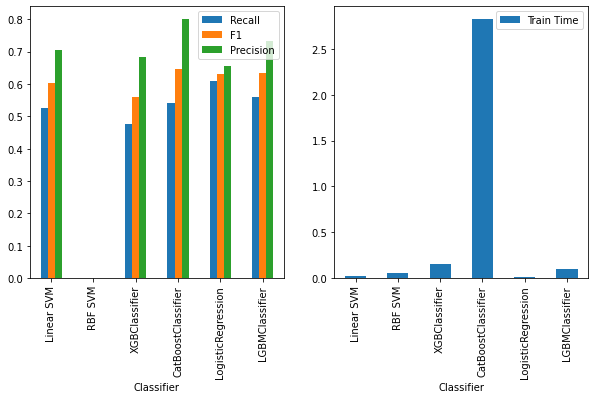

In [61]:
#a plot comparing the perfomance of the different models
fig, ax = plt.subplots(1,2, figsize=(10, 5))
results.plot(y=['Recall','F1','Precision',], kind='bar', ax=ax[0], xlim=[0,1.1]) 
results.plot(y='Train Time', kind='bar', ax=ax[1])

In terms of all the metrics except for the recall score, that is, accuracy, f1 and precision scores, CatBoostClassifier perfomed the best but it took the most time training than all the other models.Whereas in terms of the recall score, logistic regression perfomed the best, this could be because the dataset is linearly separable, as it has also been confirmed by the great perfomance of the linear kernel SVM over the non-linear, RBF SVM.


On the other hand the RBF SVM perfomed the worst by measure of all metrics.
Notably, the Linear RBF perfomed better by measure of all metrics than its counterpart the RBF SVM. This could be attributed to the large number of features in the data set giving the linear kernel an upperhand, as there is no need to map data to a higher dimensional space. The nonlinear mapping of the RBF Kernel does not improve the performance making the linear kernel good enough, and one only searches for the parameter C.
Another reason could be that since Linear SVM is a parametric model, but an RBF kernel SVM isn't, so the complexity of the latter grows with the size of the training set yet the RBF SVM for this experiment has only been exposed to a small training set.

## 5.2 Models Optimization
In the next steps we will be optimizing the perfomance of  LGBMClassifier and LogisticRegression Classifiers using GridSearchCV and also checking for features importance for each model. If time allows we will also touch on the CatBoostClassifier model, time is a concern for this model, considering it's training time and also time it'd take in a GridSearchCV.

We will also be training the models on selected few features that will be informed by mlextend's sequential forward selector as discussed earlier in the exploratory data analysis.

### 5.2a) Logistic Regression model

In [112]:
#instantiating the logisticregression model
lr_sfs = LogisticRegression()

In [113]:
#Now building the forward feature selector
sfs = sfs(lr_sfs, k_features=50, forward=True, scoring='f1', cv=5)

In [114]:
#fitting the sfs on the training set
sfs = sfs.fit(X_train, y_train)

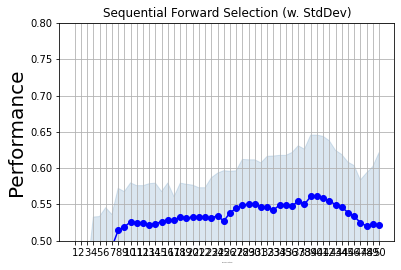

In [115]:
# Plot the results
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

axes = plt.gca()

axes.xaxis.label.set_size(1)
axes.yaxis.label.set_size(20)

plt.ylim([0.5, 0.8])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

From the plotting the results we can see that performance of the LogisticRegression model is at it's best perfomance at with 32 features, after which the perfomance drops off with every additional feature.
Let's look into those 32 features and use them to train our classifier. To be clear, these are not necessarily the first 32 features, but the 32 features which, when combined, produce optimal performance.

In [116]:
# Extracting the feature names for the optimal number using the dictionary provided by the subsets_ method
columns = list(sfs.subsets_[32]['feature_idx'])

In [ ]:
#To see the 32 feature names uncomment the codes below
#X_names = data_out.columns
#print(X_names[columns])

In [117]:
#now selecting these features for both train and test sets
X_train_sfs = X_train[:, columns]
X_test_sfs = X_test[:, columns]

In [118]:
#now training the model on the reduced set
lr_sfs.fit(X_train_sfs, y_train)

LogisticRegression()

In [119]:
#predicting
pred_lr_sfs = lr_sfs.predict(X_test_sfs)

In [120]:
#assigning metrics
f1_sfs = f1_score(y_test, pred_lr_sfs)
precision_sfs = precision_score(y_test, pred_lr_sfs)
recall_sfs = recall_score(y_test, pred_lr_sfs)
accuracy_sfs = accuracy_score(y_test, pred_lr_sfs)

In [121]:
print(f'f1 score = {f1_sfs}\n precision = {precision_sfs}\n recall = {recall_sfs}\n accuracy = {accuracy_sfs}  ')

f1 score = 0.6055045871559633
 precision = 0.66
 recall = 0.559322033898305
 accuracy = 0.785  


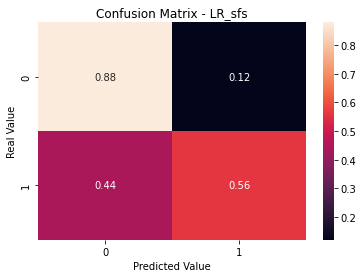

In [122]:
# confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, pred_lr_sfs, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix - LR_sfs')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Real Value')

plt.show()

Well, there's notably a great drop in model perfomance by measure of the metrics, accuracy, recall and f1 scores except for the precision score which has a slight increase of 0.005455. 

In the next step we will be tuning the hyperparameters to see how the model perfoms on these selected features dataset and also on the full features dataset.
The choice of the hyperparameters value will be informed by GridSearchCV which will be scoring using the F1 score value.

In [123]:
#doing gridsearchcv on the logisticregression model
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'saga']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,C=c_values)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=10, scoring='f1',error_score=0)
grid_result = grid_search.fit(X_train_sfs, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.549190 using {'C': 0.01, 'solver': 'liblinear'}


In [124]:
#now using the best parameters as given by the GridSearchCV
lr_sfs2 = LogisticRegression(C=0.01, solver= 'liblinear' )

In [125]:
#now training the model on the reduced set
lr_sfs2.fit(X_train_sfs, y_train)

LogisticRegression(C=0.01, solver='liblinear')

In [126]:
#predicting
pred_lr_sfs2 = lr_sfs2.predict(X_test_sfs)

In [127]:
#assigning metrics
f1_sfs2 = f1_score(y_test, pred_lr_sfs2)
precision_sfs2 = precision_score(y_test, pred_lr_sfs2)
recall_sfs2 = recall_score(y_test, pred_lr_sfs2)
accuracy_sfs2 = accuracy_score(y_test, pred_lr_sfs2)

In [128]:
print(f'f1 score = {f1_sfs2}\n precision = {precision_sfs2}\n recall = {recall_sfs2}\n accuracy = {accuracy_sfs2}  ')

f1 score = 0.6296296296296295
 precision = 0.6938775510204082
 recall = 0.576271186440678
 accuracy = 0.8  


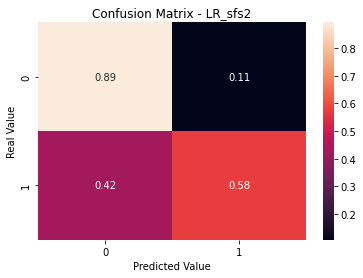

In [129]:
# confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, pred_lr_sfs2, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix - LR_sfs2')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Real Value')

plt.show()

This looks good!
The model perfomance has improved by meaasure of all the metrics that is accuracy, recall,f1 and precision scores!
From the confusion matrix as well, there's an increase in true positive rate, also equal to the recall score, from o.56 to 0.58. It is also a good sign that the specificity of the model, also known as the true negative rate has increased from 0.88 to 0.89.


The recall score is a measure of 'sensitivity' or 'the true positive rate'. This referes to when the actual value is positive, how often is the prediction correct? 

It is worth noting that as for this task, it is very important to optimize on the sensitivity of the model. To mean, how sensitive is the model to detecting positive instances. In our case, the positive instances are the bad debtors. It's not good for business, when the model predicts bad debtors as good ones, it's a lesser 'crime' however if the model on rare occasions predicts good debtors as bad ones!

Let's see how the model perfoms on the full data set with some different hyperparameters.

In [130]:
#Now fiiting the GridSearchCV on the full dataset
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'saga']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,C=c_values)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=10, scoring='f1',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.547644 using {'C': 0.01, 'solver': 'liblinear'}


In [131]:
#The GridSearchCV recommends similar hyperparameters for the full dataset as the one on a selected few features
#now fitting the new logistic regression on the full features dataset
lr3 = LogisticRegression(C= 0.01, solver= 'liblinear')

In [132]:
#now training the model on the reduced set
lr3.fit(X_train, y_train)

LogisticRegression(C=0.01, solver='liblinear')

In [133]:
#predicting
pred_lr3 = lr3.predict(X_test)

In [134]:
#assigning metrics
f1_s3 = f1_score(y_test, pred_lr3)
precision_s3 = precision_score(y_test, pred_lr3)
recall_s3 = recall_score(y_test, pred_lr3)
accuracy_s3 = accuracy_score(y_test, pred_lr3)

In [135]:
print(f'f1 score = {f1_s3}\n precision = {precision_s3}\n recall = {recall_s3}\n accuracy = {accuracy_s3}  ')

f1 score = 0.6153846153846154
 precision = 0.6206896551724138
 recall = 0.6101694915254238
 accuracy = 0.775  


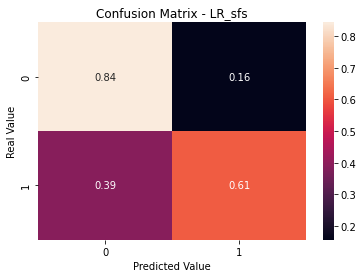

In [136]:
# confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, pred_lr3, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix - LR_sfs')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Real Value')

plt.show()

This tuned model fitted on the full features datasets perfoms better on the recall score. Also indicated by the confusion matrix, is the true positive ratio which has an increase from 0.58 to 0.61 in the. On the hand, the True negative ratio of the model has made a big drop from 0.89 to 0.84. Quite a trade-off!


Let's look at a visualization of all the perfomances for more clarity.

In [137]:
#creating a pandas dataframe of all the different LogisticRegression perfomances.
perfomance=pd.DataFrame({
            'Accuracy':[0.790,0.785,0.8,0.775],
            'Precision':[0.654545,0.66,0.69388,0.62069],
            'Recall':[0.610169,0.5593,0.57627,0.610169],
            'F1':[0.631579,0.6055,0.62963,0.6153846]},
            index=['base_lr_full','base_lr_few','tuned_lr_few','tuned_lr_full'])

Text(0, 0.5, 'scores')

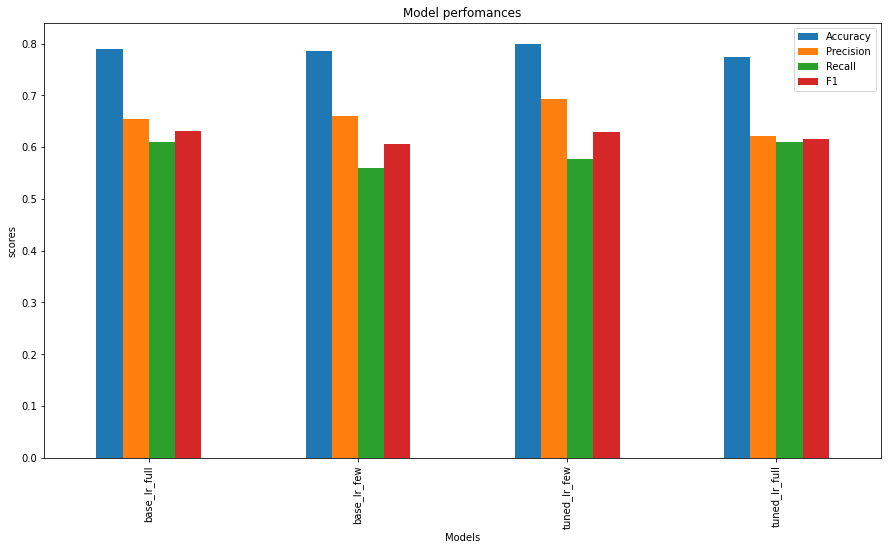

In [138]:
perfomance.plot(kind="bar",figsize=(15, 8))

plt.title("Model perfomances")

plt.xlabel("Models")

plt.ylabel("scores")

There is a major tradeoff between the precision and recall scores for each model. 
The base model and the tuned model trained on the full dataset show impressive perfomances, with a beautiful balance in the recall, precision and f1 scores!

The model trained on selected few features, both tuned and base, seem to have impressive accuracy scores but a bigger margin trade-off between precision and recall scores.

Now onto the LGBMClassifier model

### 5.2b) LGBMClassifier

In [139]:
#instantiating the LGBMClassifier model
lg = LGBMClassifier()

In [142]:
#Now building the forward feature selector
sfs_lg = sfs(lg, k_features=50, forward=True, scoring='f1', cv=5)

In [143]:
#fitting sfs for LGBMClassifier
sfs_lg = sfs_lg.fit(X_train, y_train)

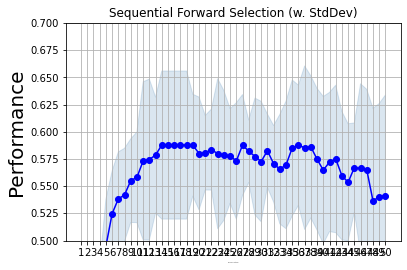

In [144]:
# Plot the results
fig1 = plot_sfs(sfs_lg.get_metric_dict(), kind='std_dev')

axes = plt.gca()

axes.xaxis.label.set_size(1)
axes.yaxis.label.set_size(20)

plt.ylim([0.5, 0.7])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

The feature selection based on LGBMClassifier has the same highest perfomance score with 36, 27, 14,15,16,17,18,19 features. Notice the constancy at 14 to 19 feature. 

we really are spoilt for choice in selecting the number of features to work with!
Let's build the model with 36 features! and see how it perfoms with different hyper-parameters.

In [163]:
# Extracting the feature names for the optimal number using the dictionary provided by the subsets_ method
columns = list(sfs_lg.subsets_[36]['feature_idx'])

In [161]:
#To see the 36 feature names uncomment the codes below
#X_names = data_out.columns
#print(X_names[columns])

Index(['Duration', 'Amount', 'NumberExistingCredits',
       'NumberPeopleMaintenance', 'x2_Furniture', 'x2_New Car', 'x2_Other',
       'x2_Repairs', 'x2_Training', 'x2_Used Car', 'x2_Vacation', 'x3_Y',
       'x4_Y', 'x5_Y', 'x6_Y', 'x7_Y', 'x8_Y', 'x9_Y', 'x10_Y', 'x11_Y',
       'x12_Y', 'x13_Y', 'x17_Y', 'x18_Y', 'x19_Y', 'x20_Y', 'x24_Y', 'x25_Y',
       'x27_Y', 'x30_Y', 'x31_Y', 'x33_Y', 'x34_Y', 'x36_Y', 'x37_Y', 'x40_Y'],
      dtype='object')


In [164]:
#now selecting these features for both train and test sets
X_train_lgsf = X_train[:, columns]
X_test_lgsf = X_test[:, columns]

In [165]:
#now training the model on the reduced set
lg.fit(X_train_lgsf, y_train)

LGBMClassifier()

In [169]:
#predicting
pred_lgsf = lg.predict(X_test_lgsf)

In [170]:
#assigning metrics
f1_lgsf = f1_score(y_test, pred_lgsf)
precision_lgsf = precision_score(y_test, pred_lgsf)
recall_lgsf = recall_score(y_test, pred_lgsf)
accuracy_lgsf = accuracy_score(y_test, pred_lgsf)

In [171]:
print(f'f1 score = {f1_lgsf}\n precision = {precision_lgsf}\n recall = {recall_lgsf}\n accuracy = {accuracy_lgsf}  ')

f1 score = 0.6538461538461539
 precision = 0.7555555555555555
 recall = 0.576271186440678
 accuracy = 0.82  


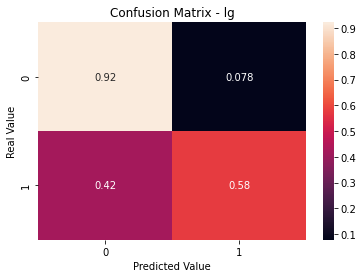

In [192]:
# confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, pred_lgsf, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix - lg')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Real Value')

plt.show()

The LGBMClassifier in it's default hyper-parameters trained on the 36 selected features, has a positive improvement by measure of all metrics as compared to when it was trained on the full dataset.
What stands out in these scores, however, is the great score in true positive ratio of 0.92(from the confusion matrix) as compared to the logisticRegression one whose highest was at 0.89. 

Let's see how it perfoms on different hyperparameters obtained after GridSearchCV.

In [173]:
#doing gridsearchcv on the selected few feature dataset
model = LGBMClassifier()  
num_leaves = [3,5,7,10, 12, 15, 20 ]
max_depth = [1,2,3,5,8,10,12, 20]
learning_rate = [0.1, 0.01, 0.001, 0.0001]
min_data_in_leaf =[ 25, 30, 35, 40,45]
 
# define grid search
grid = dict(num_leaves=num_leaves, max_depth=max_depth, learning_rate=learning_rate,min_data_in_leaf=min_data_in_leaf)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=10, scoring='f1',error_score=0)
grid_result = grid_search.fit(X_train_lgsf, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.578536 using {'learning_rate': 0.1, 'max_depth': 8, 'min_data_in_leaf': 30, 'num_leaves': 20}


In [ ]:
#Best: 0.570924 using {'learning_rate': 0.1, 'max_depth': 10, 'min_data_in_leaf': 30, 'min_sum_hessian_in_leaf': 7, 'num_leaves': 10}

In [179]:
#instantiating the LGBMClassifier with the best parameters
lg2 = LGBMClassifier(learning_rate= 0.1, max_depth= 8, min_data_in_leaf= 30, num_leaves= 20)

In [180]:
#now training the tuned model on the reduced set
lg2.fit(X_train_lgsf, y_train)

LGBMClassifier(max_depth=8, min_data_in_leaf=30, num_leaves=20)

In [181]:
#predicting
pred_lg2 = lg2.predict(X_test_lgsf)

In [182]:
#assigning metrics
f1_lg2 = f1_score(y_test, pred_lg2)
precision_lg2 = precision_score(y_test, pred_lg2)
recall_lg2 = recall_score(y_test, pred_lg2)
accuracy_lg2 = accuracy_score(y_test, pred_lg2)

In [183]:
print(f'f1 score = {f1_lg2}\n precision = {precision_lg2}\n recall = {recall_lg2}\n accuracy = {accuracy_lg2}  ')

f1 score = 0.6476190476190476
 precision = 0.7391304347826086
 recall = 0.576271186440678
 accuracy = 0.815  


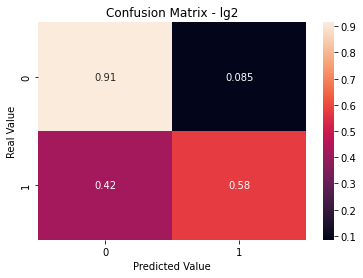

In [193]:
# confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, pred_lg2, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix - lg2')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Real Value')

plt.show()

For the tuned model fitted on the selected few features, the recall score has remained the same as compared to the base model trained on the same feature. The accuracy, f1 and precision scores have all made a slight drop.
From the cofusion matrix, the true negative ratio has made a slight drop from 0.92 to 0.91 while the false positive ratio has increased from 0.078 to 0.085.

Let's train a tuned LGBMClassifier model on the full feature data set and see how it perfoms.

In [174]:
#doing gridsearchcv on the full feature dataset
model = LGBMClassifier()  
num_leaves = [3,5,7,10, 20, 30, 40, 50 ]
max_depth = [1,2,3,5,10,12, 20,25]
learning_rate = [0.1, 0.01, 0.001, 0.0001]
min_data_in_leaf =[10,15,20, 25, 30, 35, 40, 50, 70, 100]
  
# define grid search
grid = dict(num_leaves=num_leaves, max_depth=max_depth, learning_rate=learning_rate, min_data_in_leaf = min_data_in_leaf)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=10, scoring='f1',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.547580 using {'learning_rate': 0.1, 'max_depth': 20, 'min_data_in_leaf': 15, 'num_leaves': 20}


In [186]:
lg3 = LGBMClassifier(learning_rate= 0.1, max_depth= 20, min_data_in_leaf= 15, num_leaves= 20)

In [187]:
#now training the tuned model on the full data set
lg3.fit(X_train, y_train)

LGBMClassifier(max_depth=20, min_data_in_leaf=15, num_leaves=20)

In [188]:
#predicting
pred_lg3 = lg3.predict(X_test)

In [189]:
#assigning metrics
f1_lg3 = f1_score(y_test, pred_lg3)
precision_lg3 = precision_score(y_test, pred_lg3)
recall_lg3 = recall_score(y_test, pred_lg3)
accuracy_lg3 = accuracy_score(y_test, pred_lg3)

In [190]:
print(f'f1 score = {f1_lg3}\n precision = {precision_lg3}\n recall = {recall_lg3}\n accuracy = {accuracy_lg3}  ')

f1 score = 0.6181818181818182
 precision = 0.6666666666666666
 recall = 0.576271186440678
 accuracy = 0.79  


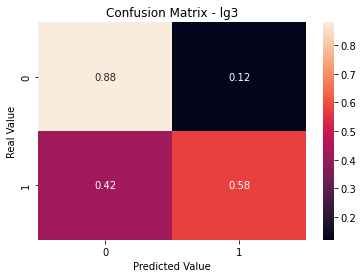

In [194]:
# confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, pred_lg3, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix - lg3')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Real Value')

plt.show()

For this tuned LGBMClassifier trained on the full data set, the perfomance is lowest for accuracy, precision,recall and f1 scores as compared to the other three LGBMClassifier models. However, what stands out is the fact that the recall score has remained constant across the  for different LGBMClassifier models.

In this model case however, it has registered the lowest True Negative ratio score of 0.88 as compared to the other LGBMClassifier models with the highest being 0.92 registered by the base LGBMClassifier trained on a few selected features.

Let's see a visualization of the four models for more clarity!

In [44]:
#creating a pandas dataframe of all the different LogisticRegression perfomances.
lg_perfomance=pd.DataFrame({
            'Accuracy':[0.810,0.82,0.815,0.79],
            'Precision':[0.73333,0.7555,0.7391,0.66667],
            'Recall':[0.559322,0.57627,0.57627,0.57627],
            'F1':[0.634615,0.653846,0.647619,0.61818]},
            index=['base_lg_full','base_lg_few','tuned_lg_few','tuned_lg_full'])


Text(0, 0.5, 'scores')

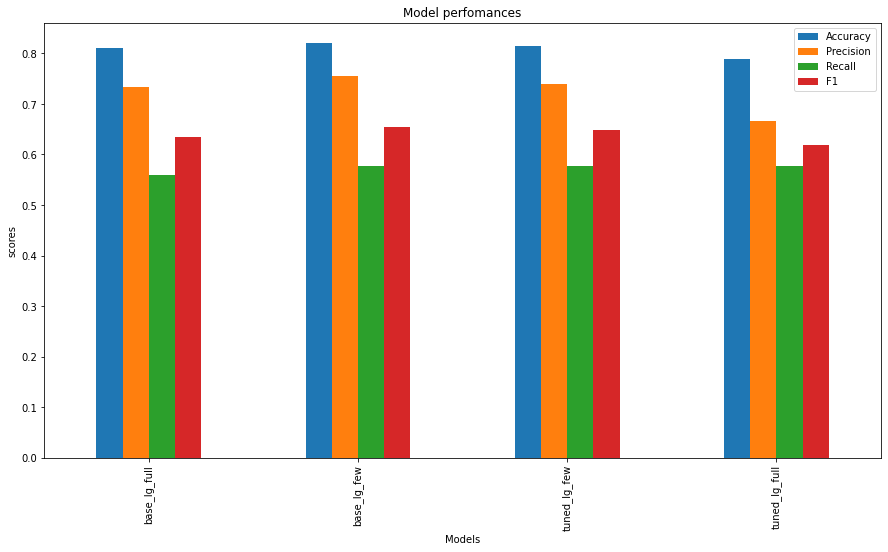

In [45]:
lg_perfomance.plot(kind="bar",figsize=(15, 8))

plt.title("Model perfomances")

plt.xlabel("Models")

plt.ylabel("scores")

From the graph above, we can see that the base LGBMClassifier model trained on the selected few features(base_lg_few) perfomed the best. It has the highest score for the metrics, accuracy, precision, recall and f1 scores as compared to the other three models.

The tuned model(tuned_lg_full) trained on the full dataset has the lowest accuracy(0.79), precision(0.66667) and f1(0.61818) scores with the base model(base_lg_full) having the lowest recall score of 0.559322.

Comparing the perfomance of the two model types, LogisticRegression and LGBMClassifier, I noticed that the LGBMClassifier models perfomed better on accuracy, precision, and f1 scores while the LogisticRegression models perforemd better by the recall score.  
For this task, maximizing the recall score while maintaining a good precision score is of great importance as it's not good for business if the model registers a huge number of bad debtors as good ones.


In the next steps we will attempt to improve the sensitivity of the base LogisticRegression trained on all features.
This will be achieved increasing the probability of the model of predicting the bad debtors whose value will be advised by the threshold obtained from the roc_curve function. The roc_curve which stands for “receiver operating characteristic” curve is useful in determining the best cutoff value for predicting whether a new observation is a 'negative' (0) or a 'positive' (1).

In [46]:
#instantiating the logisticregression model
mlr = LogisticRegression()

In [47]:
#fitting the model on the full trainig set
mlr.fit(X_train,y_train)

LogisticRegression()

In [62]:
#predicting
pred_mlr = mlr.predict(X_test)

In [48]:
# store the predicted probabilities for class 1
y_pred_prob = mlr.predict_proba(X_test)[:, 1]

Text(0, 0.5, 'Frequency')

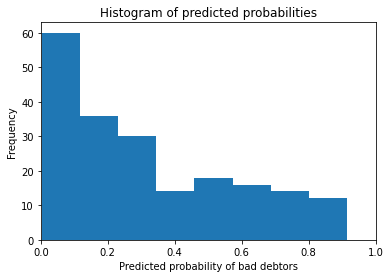

In [54]:
# histogram of predicted probabilities
# 8 bins
plt.hist(y_pred_prob, bins=8)
# x-axis limit from 0 to 1
plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of bad debtors')
plt.ylabel('Frequency')


We can see from the graph that only a small number of observations have probability greater than 0.5. This means that most would be predicted as good debtors. The solution to this, is to decrease the threshhold for predicting bad debtors which would increase the number of True Positives and in turn increase the sensitivity of the classifier.

The ROC AUC curve will help us to choose a threshold that balances sensitivity and specificity in a way that makes
sense to our context

In [66]:
# calculate roc curves
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
# get the best threshold
J = tpr - fpr    #TruePositiveRate – FalsePositiveRate
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

Best Threshold=0.373374


In [68]:
# previous confusion matrix (default threshold of 0.5)
print(metrics.confusion_matrix(y_test, pred_mlr))


[[122  19]
 [ 23  36]]


In [94]:
#metrics for the model predictions without any probability adjustments
f1_mlr = f1_score(y_test, pred_mlr)
precision_mlr = precision_score(y_test, pred_mlr)
recall_mlr = recall_score(y_test, pred_mlr)
accuracy_mlr = accuracy_score(y_test, pred_mlr)

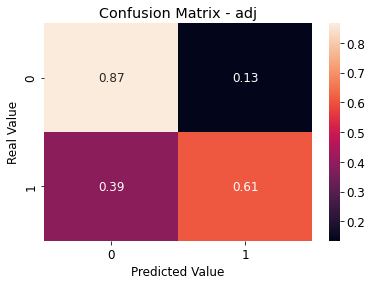

In [107]:
# confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, pred_mlr, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix - adj')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Real Value')

plt.show()

In [87]:
# new confusion matrix (threshold of 0.373374)
threshold = best_thresh
y_pred_new = (mlr.predict_proba(X_test)[:, 1] >= threshold).astype('float')
confusion_matrix(y_test, y_pred_new)

array([[114,  27],
       [ 15,  44]])

In [95]:
#metrics for the model predictions with adjusted probability threshhold
f1_new = f1_score(y_test, y_pred_new)
precision_new = precision_score(y_test, y_pred_new)
recall_new = recall_score(y_test, y_pred_new)
accuracy_new = accuracy_score(y_test, y_pred_new)

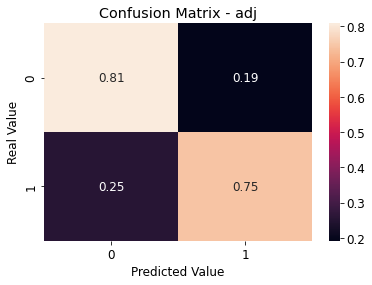

In [105]:
# confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred_new, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix - adj')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Real Value')

plt.show()

In [93]:
print(f'f1 score = {f1_new}\n precision = {precision_new}\n recall = {recall_new}\n accuracy = {accuracy_new}  ')

f1 score = 0.676923076923077
 precision = 0.6197183098591549
 recall = 0.7457627118644068
 accuracy = 0.79  


In [103]:
print(f'f1 score = {f1_mlr}\n precision = {precision_mlr}\n recall = {recall_mlr}\n accuracy = {accuracy_mlr}  ')

f1 score = 0.6315789473684211
 precision = 0.6545454545454545
 recall = 0.6101694915254238
 accuracy = 0.79  


In [99]:
#creating a pandas dataframe of all the different LogisticRegression perfomances.
perf_adj=pd.DataFrame({
            'Accuracy':[accuracy_mlr,accuracy_new],
            'Precision':[precision_mlr,precision_new],
            'Recall':[recall_mlr,recall_new],
            'F1':[f1_mlr,f1_new]},
            index=['default_prob','adj_prob'])

Text(0, 0.5, 'scores')

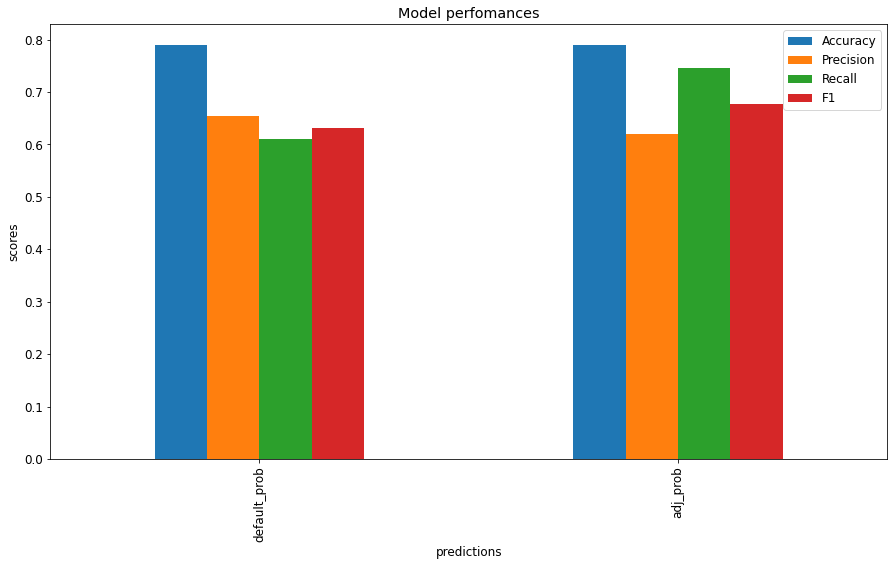

In [102]:
perf_adj.plot(kind="bar",figsize=(15, 8))

plt.title("Model perfomances")

plt.xlabel("predictions")

plt.ylabel("scores")

Well, lowering the threshold for probability, increases the True Positive score in our prediction from 36 to 44 and also lowers the True Negative count from 112 to 114. It also increases the recall score from 0.610169 to 0.745762 and the f1 score from 0.63158 to 0.6769. On the other hand it lowers the precision score from 0.6545 to 0.61972.


# Conclusion

The main objective of this task was to build a machine learning algorithm that would be able to identify bad debtors and therefore reduce ABC company loss. The best model possible would be the one that could minimize false negatives, identifying all bad debtors among the client base, while also minimizing false positives, preventing clients to be wrongly classified as bad debtors.

Often there is a tradeoff between precision and recall scores, meaning that increasing the value of one of these metrics will more likely decrease the value of the other. Considering the importance of minimizing company loss, I gave more emphasis on reducing the false positives, searching for the best hyperparameters that could increase the recall rate.


Of all the models trained, the LogisticRegression predictions adjusted on probabilities, had the highest recall score of 0.745762 and a false positive ratio of 19%.
In terms of precision, The LGBMClassifier model trained on a few selcted features had the highest score of 0.7555 and a false positive ratio of 7.8%.

A dillema may arise on which metric to use in picking the best model to use. Well in such a case, the decision\solution will be informed by the situation at that particular moment in business. 


To capture more good debtors, then the default model and the LGBMClassifier base model trained on selected few features will both perfom impressively. 

To capture more bad debtors before hand, then the predictions after adjusting the prediction probability for the LogisticRegression base model will do just that!
Also the LGBMClassifier base model trained on only selected few features will perfom well on the same.

Whichever model is chosen, it will be able to predict whether a client is a good or bad debtor for a given credit limit and pricing interest rate that a client is eligible for, and other factors/features considered as used in training the model.


**How can the credit scoring model for ABC Company be improved further now or in the future?**

The perfomance of the different models can be improved by:
* Further tuning the hyperparameters of the models trained in this notebook
* Training more different models like the unsupervised models
* Exposing these models built or other new ones to datasets with more observations as this increases the ability of a model to perfom well on unseen data.